# Natural Language Processing with Deep Learning (7 points)

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://kaggle2.blob.core.windows.net/competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model ca access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

In [2]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
193962,71774524,C NET Developer With Silverlight Manchester C...,C .NET Developer With Silverlight Manchester ...,Lancashire Manchester M21 0,Manchester Science Park,NaN,permanent,MNM Associates LTD,IT Jobs,30000.00 - 35000.00 GBP Annual,32500,jobserve.com,10.389026
166313,71296911,Excel Administrator,An established corporate company in Northampto...,Northamptonshire,Northamptonshire,NaN,contract,Office Angels,Admin Jobs,8/hour,15360,cv-library.co.uk,9.639587
139918,70566202,Registered Nurses,The Medic Alert Foundation provides lifesaving...,Milton Keynes,Milton Keynes,part_time,NaN,Medical Alert,Healthcare & Nursing Jobs,"14,285",14285,jobstoday.co.uk,9.567036


### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [3]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [4]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [5]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [6]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in "Title" and "FullDescription"
for title in data["Title"]:
    for word in title.split():
        token_counts[word] += 1
for description in data["FullDescription"]:
    for word in description.split():
        token_counts[word] += 1

In [7]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))
print(token_counts.most_common(1)[0][1])

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
2657388
Correct!


Text(0.5,0,'Counts')

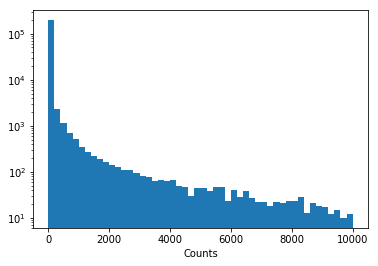

In [8]:
# Let's see how many words are there for each count

_=plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [9]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [token for token,value in token_counts.items() if value > 10]

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [10]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 32456
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [11]:
token_to_id = dict((tokens[i],i) for i in range(len(tokens)))

In [12]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [13]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [14]:
#### print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[   2    3    4    1    1]
 [ 996  176    1    1    1]
 [  18 3461  242   59    6]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [15]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
        sparse=False)

In [16]:
len(categorical_vectorizer.get_feature_names())

3768

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [17]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [18]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)
    
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

In [19]:
generate_batch(data_train, 3, max_len=10)

{'Title': array([[  18, 1117, 1121,   63,  203,  172,   64],
        [ 105,  781, 1235,    1,    1,    1,    1],
        [1594,    9, 1372,   23,  309,  298,    1]], dtype=int32),
 'FullDescription': array([[   18,  1117,  1121,    63,   203,   172,    64, 16567,   704,
           478],
        [   80,  1164,   105,   781,     0,  1164,    74,  2152,  1164,
            92],
        [  360,  3020,  1164,  1594,     9,  1372,    23,  2152,  1164,
           309]], dtype=int32),
 'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'Log1pSalary': array([ 9.64866 , 10.085851, 10.915107], dtype=float32)}

### Finally, let's talk deep learning

Out model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [20]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [28]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()        
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = self.pool1(h)
        h = F.relu(self.dense(h))
        return h

In [29]:
title_encoder = TitleEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

Seems fine


__Task 2.1__ Create description encoder

In [30]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=5, padding=1)
        self.pool1 = GlobalMaxPooling()        
        self.dense = nn.Linear(out_size, out_size)
        

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = self.pool1(h)
        h = F.relu(self.dense(h))
        return h

In [32]:
desc_encoder = DescriptionEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['FullDescription']))
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

Seems fine too


__ Task 2.2__ Build one network ~~to rule them all~~

In [88]:
class CategoricalEncoder(nn.Module):
    def __init__(self,n_cat_features,l_dims):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        l_dims = [n_cat_features]+l_dims
        self.dense_layers = nn.ModuleList()
        for i in range(1,len(l_dims)):
            self.dense_layers.append(nn.Linear(l_dims[i-1],l_dims[i]))

    def forward(self, x):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        for l in self.dense_layers:
            x = F.relu(l(x))
        return x

In [89]:
class OutputLayers(nn.Module):
    def __init__(self,n_concat,l_dims):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        l_dims = [n_concat]+l_dims
        self.dense_layers = nn.ModuleList()
        for i in range(1,len(l_dims)):
            self.dense_layers.append(nn.Linear(l_dims[i-1],l_dims[i]))
        self.last_layer = nn.Linear(l_dims[-1],1)

    def forward(self, x):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        for l in self.dense_layers:
            x = F.relu(l(x))
        return self.last_layer(x)

In [90]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        out_size_t, out_size_d = 64,64
        self.title_encoder = TitleEncoder(out_size=out_size_t)
        self.desc_encoder = DescriptionEncoder(out_size=out_size_d)
        
        # define layers for categorical features. A few dense layers would do.
        l_dims = [300,100,20]
        self.cat_encoder = CategoricalEncoder(n_cat_features,l_dims)
        
        # define "output" layers that process depend the three encoded vectors into answer
        n_concat = out_size_t + out_size_d + l_dims[-1]
        self.out_layers = OutputLayers(n_concat,[100,80,30])
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.cat_encoder(cat_features)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        output = self.out_layers(joint_h)
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return output[:,0]

In [96]:
model = FullNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [69]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = Variable(torch.LongTensor(batch["Title"]))
desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
reference = Variable(torch.FloatTensor(batch[target_column]))

prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [21]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [71]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it!

In [22]:
from tqdm import tnrange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=False):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [73]:
num_epochs = 100
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [97]:
device = torch.device("cuda")
model.to(device)

FullNetwork(
  (title_encoder): TitleEncoder(
    (emb): Embedding(32456, 64, padding_idx=1)
    (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (pool1): GlobalMaxPooling()
    (dense): Linear(in_features=64, out_features=64, bias=True)
  )
  (desc_encoder): DescriptionEncoder(
    (emb): Embedding(32456, 64, padding_idx=1)
    (conv1): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(1,))
    (pool1): GlobalMaxPooling()
    (dense): Linear(in_features=64, out_features=64, bias=True)
  )
  (cat_encoder): CategoricalEncoder(
    (dense_layers): ModuleList(
      (0): Linear(in_features=3768, out_features=300, bias=True)
      (1): Linear(in_features=300, out_features=100, bias=True)
      (2): Linear(in_features=100, out_features=20, bias=True)
    )
  )
  (out_layers): OutputLayers(
    (dense_layers): ModuleList(
      (0): Linear(in_features=148, out_features=100, bias=True)
      (1): Linear(in_features=100, out_features=80, bias=True)
      (2): Linea

In [98]:
history_train = []
history_val = []
 
for epoch_i in tnrange(num_epochs):
    history_train = []
    history_val = []
 
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):

        title_ix = torch.tensor(batch["Title"],dtype=torch.long,device=device)
        desc_ix = torch.tensor(batch["FullDescription"],dtype=torch.long,device=device)
        cat_features = torch.tensor(batch["Categorical"],dtype=torch.float32,device=device)
        reference = torch.tensor(batch[target_column],dtype=torch.float32,device=device)

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.cpu().numpy()
        train_mae += compute_mae(reference, prediction).data.cpu().numpy()
        train_batches += 1
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    history_train.append(train_loss / train_batches)
    
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    for batch in iterate_minibatches(data_val, max_batches=batches_per_epoch, shuffle=False):
        title_ix = torch.tensor(batch["Title"],dtype=torch.long,device=device)
        desc_ix = torch.tensor(batch["FullDescription"],dtype=torch.long,device=device)
        cat_features = torch.tensor(batch["Categorical"],dtype=torch.float32,device=device)
        reference = torch.tensor(batch[target_column],dtype=torch.float32,device=device)


        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.cpu().numpy()
        val_mae += compute_mae(reference, prediction).data.cpu().numpy()
        val_batches += 1
        
    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')
    
    history_val.append(val_loss / val_batches)

Training:
	Loss:	18.42079
	MAE:	58668.13160



Validation:
	Loss:	0.65807
	MAE:	7075.77153



Training:
	Loss:	0.51270
	MAE:	6848.67526



Validation:
	Loss:	0.45235
	MAE:	5925.86479



Training:
	Loss:	0.41063
	MAE:	5924.03076



Validation:
	Loss:	0.39919
	MAE:	5135.83520



Training:
	Loss:	0.31910
	MAE:	5246.89538



Validation:
	Loss:	0.31366
	MAE:	5486.39947



Training:
	Loss:	0.28229
	MAE:	4941.57447



Validation:
	Loss:	0.26432
	MAE:	4502.86168



Training:
	Loss:	0.24393
	MAE:	4752.18316



Validation:
	Loss:	0.23733
	MAE:	4633.34705



Training:
	Loss:	0.23023
	MAE:	4464.12187



Validation:
	Loss:	0.24326
	MAE:	4180.06699



Training:
	Loss:	0.19980
	MAE:	4224.38859



Validation:
	Loss:	0.21963
	MAE:	4077.46270



Training:
	Loss:	0.19805
	MAE:	4194.70801



Validation:
	Loss:	0.18943
	MAE:	3933.80442



Training:
	Loss:	0.18998
	MAE:	4099.77887



Validation:
	Loss:	0.17707
	MAE:	3982.67648



Training:
	Loss:	0.19285
	MAE:	4217.31774



Validation:
	Loss:	0.22677
	MAE:	

	Loss:	0.09216
	MAE:	3022.95020



Validation:
	Loss:	0.09727
	MAE:	3182.01569



Training:
	Loss:	0.09365
	MAE:	2971.20906



Validation:
	Loss:	0.11297
	MAE:	3504.09428



Training:
	Loss:	0.08672
	MAE:	2872.37007



Validation:
	Loss:	0.09935
	MAE:	2971.80153



Training:
	Loss:	0.09668
	MAE:	3037.74942



Validation:
	Loss:	0.08711
	MAE:	2873.15295



Training:
	Loss:	0.08470
	MAE:	2744.53578



Validation:
	Loss:	0.11047
	MAE:	3420.22981



Training:
	Loss:	0.10253
	MAE:	3112.45111



Validation:
	Loss:	0.08250
	MAE:	2780.13260



Training:
	Loss:	0.08116
	MAE:	2733.90247



Validation:
	Loss:	0.07934
	MAE:	2695.79687



Training:
	Loss:	0.08015
	MAE:	2723.93637



Validation:
	Loss:	0.10554
	MAE:	3341.56939



Training:
	Loss:	0.08264
	MAE:	2749.67072



Validation:
	Loss:	0.07879
	MAE:	2687.63505



Training:
	Loss:	0.07712
	MAE:	2679.51910



Validation:
	Loss:	0.08819
	MAE:	2990.15232



Training:
	Loss:	0.07224
	MAE:	2578.41708



Validation:
	Loss:	0.08410
	MAE:	2879.63493



In [99]:
torch.save(model,"models/conv_1d.model")

/usr/lib/python3.7/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type FullNetwork. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/lib/python3.7/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type TitleEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/lib/python3.7/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type GlobalMaxPooling. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/lib/python3.7/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type DescriptionEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/lib/python3.7/site

In [100]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

for batch in iterate_minibatches(data_val, shuffle=False):
    title_ix = torch.tensor(batch["Title"],dtype=torch.long,device=device)
    desc_ix = torch.tensor(batch["FullDescription"],dtype=torch.long,device=device)
    cat_features = torch.tensor(batch["Categorical"],dtype=torch.float32,device=device)
    reference = torch.tensor(batch[target_column],dtype=torch.float32,device=device)

    prediction = model(title_ix, desc_ix, cat_features)
    loss = compute_loss(reference, prediction)

    val_loss += loss.data.cpu().numpy()
    val_mae += compute_mae(reference, prediction).data.cpu().numpy()
    val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:
	Loss:	0.08744
	MAE:	2937.63382





### Task 3.2: Actually make it work

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__.

Try __at least 3 options__ from the list below for a passing grade. If you're into 

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

#### C) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order, 
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

## A short report

Please tell us what you did and how did it work.


### Improve CNN architecture

### Added parallel conv layers and batchnorm

In [23]:
class CategoricalEncoder(nn.Module):
    def __init__(self,n_cat_features,l_dims):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        l_dims = [n_cat_features]+l_dims
        self.dense = nn.ModuleList()
        self.bn = nn.ModuleList()
        for i in range(1,len(l_dims)):
            self.dense.append(nn.Linear(l_dims[i-1],l_dims[i]))
            self.bn.append(nn.BatchNorm1d(l_dims[i]))

    def forward(self, x):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        for i in range(len(self.dense)):
            x = self.dense[i](x)
            x = self.bn[i](x)
            x = F.relu(x)
        return x

In [24]:
class OutputLayers(nn.Module):
    def __init__(self,n_concat,l_dims):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        l_dims = [n_concat]+l_dims
        self.dense = nn.ModuleList()
        self.bn = nn.ModuleList()
        for i in range(1,len(l_dims)):
            self.dense.append(nn.Linear(l_dims[i-1],l_dims[i]))
            self.bn.append(nn.BatchNorm1d(l_dims[i]))
        self.last_layer = nn.Linear(l_dims[-1],1)

    def forward(self, x):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        for i in range(len(self.dense)):
            x = self.dense[i](x)
            x = self.bn[i](x)
            x = F.relu(x)
        return self.last_layer(x)

In [25]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), sizes=[48,48]):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, sizes[0], kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, sizes[1], kernel_size=5)
        self.bn = nn.BatchNorm1d(sum(sizes))
        self.pool1 = GlobalMaxPooling()        
        self.dense = nn.Linear(sum(sizes), sum(sizes))

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, size1+size2]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h1 = self.conv1(h)
        h1 = self.pool1(h1)
        h2 = self.conv2(h)
        h2 = self.pool1(h2)
        h = torch.cat([h1,h2], dim=1)
        h = self.bn(h)
        h = F.relu(self.dense(h)) 
        return h

In [26]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), sizes=[48,48,48]):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, sizes[0], kernel_size=5, padding=1)
        self.conv2 = nn.Conv1d(64, sizes[1], kernel_size=7)
        self.conv3 = nn.Conv1d(64, sizes[2], kernel_size=9)
        self.pool1 = GlobalMaxPooling()    
        self.bn = nn.BatchNorm1d(sum(sizes))
        self.dense = nn.Linear(sum(sizes), sum(sizes))
        

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h1 = self.conv1(h)
        h1 = self.pool1(h1)
        h2 = self.conv2(h)
        h2 = self.pool1(h2)
        h3 = self.conv3(h)
        h3 = self.pool1(h3)
        h = torch.cat([h1,h2,h3], dim=1)
        h = self.bn(h)
        h = F.relu(self.dense(h))
        return h

In [27]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_),
                t_sizes = [48,48], d_sizes = [48,48,48]):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(sizes=t_sizes)
        self.desc_encoder = DescriptionEncoder(sizes=d_sizes)
        
        # define layers for categorical features. A few dense layers would do.
        l_dims = [300,100,20]
        self.cat_encoder = CategoricalEncoder(n_cat_features,l_dims)
        
        # define "output" layers that process depend the three encoded vectors into answer
        n_concat = sum(t_sizes) + sum(d_sizes) + l_dims[-1]
        self.out_layers = OutputLayers(n_concat,[100,80,30])
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.cat_encoder(cat_features)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        output = self.out_layers(joint_h)
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return output[:,0]

In [28]:
def Train(model, num_epochs, opt, batch_size=32, batches_per_epoch=100):
    history_train = []
    history_val = []
    print("\n\n")
    for epoch_i in tnrange(num_epochs):
        print("Epoch "+str(epoch_i))
        print("\tTraining:")
        train_loss = train_mae = train_batches = 0
        model.train(True)

        for batch in iterate_minibatches(data_train, batch_size=batch_size, max_batches=batches_per_epoch):

            title_ix = torch.tensor(batch["Title"],dtype=torch.long,device=device)
            desc_ix = torch.tensor(batch["FullDescription"],dtype=torch.long,device=device)
            cat_features = torch.tensor(batch["Categorical"],dtype=torch.float32,device=device)
            reference = torch.tensor(batch[target_column],dtype=torch.float32,device=device)
            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)
            loss.backward()
            opt.step()
            opt.zero_grad()

            train_loss += loss.data.cpu().numpy()
            train_mae += compute_mae(reference, prediction).data.cpu().numpy()
            train_batches += 1

        print("\tLoss:\t%.5f" % (train_loss / train_batches))
        print("\tMAE:\t%.5f" % (train_mae / train_batches))

        history_train.append(train_loss / train_batches)

        print("\tValidation:")
        val_loss = val_mae = val_batches = 0
        model.train(False)

        for batch in iterate_minibatches(data_val, batch_size=batch_size, max_batches=batches_per_epoch, shuffle=False):
            title_ix = torch.tensor(batch["Title"],dtype=torch.long,device=device)
            desc_ix = torch.tensor(batch["FullDescription"],dtype=torch.long,device=device)
            cat_features = torch.tensor(batch["Categorical"],dtype=torch.float32,device=device)
            reference = torch.tensor(batch[target_column],dtype=torch.float32,device=device)
            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)

            val_loss += loss.data.cpu().numpy()
            val_mae += compute_mae(reference, prediction).data.cpu().numpy()
            val_batches += 1

        print("\tLoss:\t%.5f" % (val_loss / val_batches))
        print("\tMAE:\t%.5f" % (val_mae / val_batches))
        print('\n')

        history_val.append(val_loss / val_batches)
    return history_train, history_val

In [46]:
def Test(model):
    print("Final eval:")
    val_loss = val_mae = val_batches = 0

    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = torch.tensor(batch["Title"],dtype=torch.long,device=device)
        desc_ix = torch.tensor(batch["FullDescription"],dtype=torch.long,device=device)
        cat_features = torch.tensor(batch["Categorical"],dtype=torch.float32,device=device)
        reference = torch.tensor(batch[target_column],dtype=torch.float32,device=device)

        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.cpu().numpy()
        val_mae += compute_mae(reference, prediction).data.cpu().numpy()
        val_batches += 1

    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

In [30]:
model = FullNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [31]:
device = torch.device("cuda")
model.to(device)

FullNetwork(
  (title_encoder): TitleEncoder(
    (emb): Embedding(32456, 64, padding_idx=1)
    (conv1): Conv1d(64, 48, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(64, 48, kernel_size=(5,), stride=(1,))
    (bn): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool1): GlobalMaxPooling()
    (dense): Linear(in_features=96, out_features=96, bias=True)
  )
  (desc_encoder): DescriptionEncoder(
    (emb): Embedding(32456, 64, padding_idx=1)
    (conv1): Conv1d(64, 48, kernel_size=(5,), stride=(1,), padding=(1,))
    (conv2): Conv1d(64, 48, kernel_size=(7,), stride=(1,))
    (conv3): Conv1d(64, 48, kernel_size=(9,), stride=(1,))
    (pool1): GlobalMaxPooling()
    (bn): BatchNorm1d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dense): Linear(in_features=144, out_features=144, bias=True)
  )
  (cat_encoder): CategoricalEncoder(
    (dense): ModuleList(
      (0): Linear(in_features=3768, out_features=300, 

In [32]:
hist_train, hist_val = Train(model,100,opt,batch_size=64)

Epoch 0
	Training:
	Loss:	93.66297
	MAE:	12552.49212
	Validation:
	Loss:	82.13053
	MAE:	12605.37854


Epoch 1
	Training:
	Loss:	65.62862
	MAE:	12416.66029
	Validation:
	Loss:	47.57623
	MAE:	12594.81192


Epoch 2
	Training:
	Loss:	31.22666
	MAE:	12442.96698
	Validation:
	Loss:	17.62059
	MAE:	12428.68049


Epoch 3
	Training:
	Loss:	8.48709
	MAE:	11636.52795
	Validation:
	Loss:	2.84160
	MAE:	10283.60507


Epoch 4
	Training:
	Loss:	1.24303
	MAE:	7808.11684
	Validation:
	Loss:	0.53096
	MAE:	5941.21310


Epoch 5
	Training:
	Loss:	0.26538
	MAE:	4601.52495
	Validation:
	Loss:	0.21873
	MAE:	4162.12118


Epoch 6
	Training:
	Loss:	0.16547
	MAE:	3916.46133
	Validation:
	Loss:	0.13648
	MAE:	3551.92083


Epoch 7
	Training:
	Loss:	0.15882
	MAE:	3831.24543
	Validation:
	Loss:	0.14094
	MAE:	3641.21316


Epoch 8
	Training:
	Loss:	0.14119
	MAE:	3638.55699
	Validation:
	Loss:	0.12736
	MAE:	3400.72133


Epoch 9
	Training:
	Loss:	0.14010
	MAE:	3541.74085
	Validation:
	Loss:	0.13511
	MAE:	3568.28437


Epoch 

	Loss:	0.05641
	MAE:	2249.93825
	Validation:
	Loss:	0.06296
	MAE:	2409.10982


Epoch 84
	Training:
	Loss:	0.05771
	MAE:	2338.62519
	Validation:
	Loss:	0.06331
	MAE:	2427.66649


Epoch 85
	Training:
	Loss:	0.06523
	MAE:	2426.93880
	Validation:
	Loss:	0.06267
	MAE:	2423.04785


Epoch 86
	Training:
	Loss:	0.05989
	MAE:	2354.11109
	Validation:
	Loss:	0.06236
	MAE:	2391.22880


Epoch 87
	Training:
	Loss:	0.05847
	MAE:	2303.26594
	Validation:
	Loss:	0.06383
	MAE:	2417.18688


Epoch 88
	Training:
	Loss:	0.06165
	MAE:	2383.59711
	Validation:
	Loss:	0.06338
	MAE:	2438.16338


Epoch 89
	Training:
	Loss:	0.05437
	MAE:	2220.58772
	Validation:
	Loss:	0.06123
	MAE:	2388.94110


Epoch 90
	Training:
	Loss:	0.05711
	MAE:	2325.01708
	Validation:
	Loss:	0.06235
	MAE:	2397.16827


Epoch 91
	Training:
	Loss:	0.05729
	MAE:	2248.00828
	Validation:
	Loss:	0.06005
	MAE:	2348.97831


Epoch 92
	Training:
	Loss:	0.05606
	MAE:	2265.25553
	Validation:
	Loss:	0.06194
	MAE:	2376.35530


Epoch 93
	Training:
	Loss:	0.0

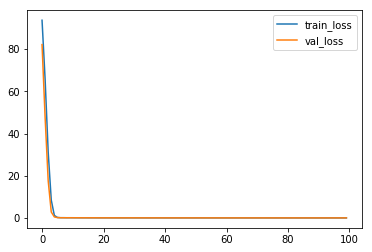

In [33]:
plt.plot((hist_train),label='train_loss')
plt.plot((hist_val),label='val_loss')
plt.legend()
plt.show()


In [34]:
torch.save(model.state_dict(),"models/conv_1d.pkl")

In [35]:
model.load_state_dict(torch.load("models/conv_1d.pkl"))

In [36]:
Test(model)

Final eval:
	Loss:	0.07527
	MAE:	2616.20195





### Try sequential conv layers

In [45]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), sizes=[64,96]):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, sizes[0], kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(sizes[0], sizes[1], kernel_size=3, padding=1)
        self.bn = nn.BatchNorm1d(sizes[-1])
        self.pool1 = GlobalMaxPooling()        
        self.dense = nn.Linear(sizes[-1], sizes[-1])

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, size1+size2]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = self.conv2(h)
        h = self.pool1(h)
        h = self.bn(h)
        h = F.relu(self.dense(h)) 
        return h

In [46]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), sizes=[48,48,48]):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, sizes[0], kernel_size=5, padding=1)
        self.conv2 = nn.Conv1d(sizes[0], sizes[1], kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(sizes[1], sizes[2], kernel_size=3,padding=1)
        self.pool1 = GlobalMaxPooling()    
        self.bn = nn.BatchNorm1d(sizes[-1])
        self.dense = nn.Linear(sizes[-1], sizes[-1])
        

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = self.conv2(h)
        h = self.conv3(h)
        h = self.pool1(h)
        h = self.bn(h)
        h = F.relu(self.dense(h))
        return h

In [47]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_),
                t_sizes = [64,96], d_sizes = [64,80,100]):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(sizes=t_sizes)
        self.desc_encoder = DescriptionEncoder(sizes=d_sizes)
        
        # define layers for categorical features. A few dense layers would do.
        l_dims = [300,100,20]
        self.cat_encoder = CategoricalEncoder(n_cat_features,l_dims)
        
        # define "output" layers that process depend the three encoded vectors into answer
        n_concat = t_sizes[-1] + d_sizes[-1] + l_dims[-1]
        self.out_layers = OutputLayers(n_concat,[100,80,30])
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.cat_encoder(cat_features)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        output = self.out_layers(joint_h)
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return output[:,0]

In [48]:
model = FullNetwork(t_sizes=[64,96],d_sizes=[64,64,96])
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cuda")
model.to(device)

FullNetwork(
  (title_encoder): TitleEncoder(
    (emb): Embedding(32456, 64, padding_idx=1)
    (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(64, 96, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool1): GlobalMaxPooling()
    (dense): Linear(in_features=96, out_features=96, bias=True)
  )
  (desc_encoder): DescriptionEncoder(
    (emb): Embedding(32456, 64, padding_idx=1)
    (conv1): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(1,))
    (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv3): Conv1d(64, 96, kernel_size=(3,), stride=(1,), padding=(1,))
    (pool1): GlobalMaxPooling()
    (bn): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dense): Linear(in_features=96, out_features=96, bias=True)
  )
  (cat_encoder): CategoricalEncoder(
    (dense): ModuleList(
      (0): Line

In [49]:
hist_train, hist_val = Train(model,30,opt,batch_size=64)

Epoch 0
	Training:
	Loss:	93.15306
	MAE:	12507.16582
	Validation:
	Loss:	79.09775
	MAE:	12605.12507


Epoch 1
	Training:
	Loss:	63.70099
	MAE:	12520.28475
	Validation:
	Loss:	49.28607
	MAE:	12596.34620


Epoch 2
	Training:
	Loss:	33.47060
	MAE:	12525.67311
	Validation:
	Loss:	20.64282
	MAE:	12468.30087


Epoch 3
	Training:
	Loss:	11.64469
	MAE:	12022.00437
	Validation:
	Loss:	5.83191
	MAE:	11490.94605


Epoch 4
	Training:
	Loss:	2.40218
	MAE:	9442.73082
	Validation:
	Loss:	0.83184
	MAE:	7234.81715


Epoch 5
	Training:
	Loss:	0.41077
	MAE:	5447.28815
	Validation:
	Loss:	0.22429
	MAE:	4408.87462


Epoch 6
	Training:
	Loss:	0.18293
	MAE:	4015.95371
	Validation:
	Loss:	0.14282
	MAE:	3643.64660


Epoch 7
	Training:
	Loss:	0.14424
	MAE:	3661.37681
	Validation:
	Loss:	0.14411
	MAE:	3702.13402


Epoch 8
	Training:
	Loss:	0.14780
	MAE:	3658.03775
	Validation:
	Loss:	0.13637
	MAE:	3547.73705


Epoch 9
	Training:
	Loss:	0.13102
	MAE:	3444.18886
	Validation:
	Loss:	0.13435
	MAE:	3521.62380


Epoch

In [50]:
hist_train, hist_val = Train(model,30,opt,batch_size=64)

Epoch 0
	Training:
	Loss:	0.08862
	MAE:	2892.74067
	Validation:
	Loss:	0.08783
	MAE:	2834.08291


Epoch 1
	Training:
	Loss:	0.09264
	MAE:	2903.86362
	Validation:
	Loss:	0.10977
	MAE:	3170.38996


Epoch 2
	Training:
	Loss:	0.10216
	MAE:	3130.34315
	Validation:
	Loss:	0.09761
	MAE:	2989.75183


Epoch 3
	Training:
	Loss:	0.09147
	MAE:	2948.83047
	Validation:
	Loss:	0.08809
	MAE:	2834.73781


Epoch 4
	Training:
	Loss:	0.08990
	MAE:	2871.09671
	Validation:
	Loss:	0.09080
	MAE:	2871.28841


Epoch 5
	Training:
	Loss:	0.09363
	MAE:	2950.14489
	Validation:
	Loss:	0.08522
	MAE:	2828.97734


Epoch 6
	Training:
	Loss:	0.09419
	MAE:	2947.78767
	Validation:
	Loss:	0.10121
	MAE:	2994.89893


Epoch 7
	Training:
	Loss:	0.08651
	MAE:	2809.40644
	Validation:
	Loss:	0.13287
	MAE:	3435.18062


Epoch 8
	Training:
	Loss:	0.08614
	MAE:	2786.51264
	Validation:
	Loss:	0.08811
	MAE:	2867.62917


Epoch 9
	Training:
	Loss:	0.08406
	MAE:	2764.61719
	Validation:
	Loss:	0.10235
	MAE:	2979.99289


Epoch 10
	Training:


In [51]:
hist_train, hist_val = Train(model,30,opt,batch_size=64)

Epoch 0
	Training:
	Loss:	0.07391
	MAE:	2588.22879
	Validation:
	Loss:	0.07322
	MAE:	2579.45926


Epoch 1
	Training:
	Loss:	0.07698
	MAE:	2652.60796
	Validation:
	Loss:	0.07255
	MAE:	2569.07401


Epoch 2
	Training:
	Loss:	0.07860
	MAE:	2672.36688
	Validation:
	Loss:	0.07599
	MAE:	2620.44395


Epoch 3
	Training:
	Loss:	0.07987
	MAE:	2694.35638
	Validation:
	Loss:	0.07086
	MAE:	2532.94814


Epoch 4
	Training:
	Loss:	0.07380
	MAE:	2588.77022
	Validation:
	Loss:	0.07710
	MAE:	2700.39670


Epoch 5
	Training:
	Loss:	0.07175
	MAE:	2585.44228
	Validation:
	Loss:	0.07363
	MAE:	2596.64253


Epoch 6
	Training:
	Loss:	0.06993
	MAE:	2529.26897
	Validation:
	Loss:	0.07546
	MAE:	2664.69852


Epoch 7
	Training:
	Loss:	0.07529
	MAE:	2630.90601
	Validation:
	Loss:	0.07382
	MAE:	2597.36595


Epoch 8
	Training:
	Loss:	0.07205
	MAE:	2554.27341
	Validation:
	Loss:	0.08119
	MAE:	2738.62479


Epoch 9
	Training:
	Loss:	0.07455
	MAE:	2661.36950
	Validation:
	Loss:	0.07525
	MAE:	2647.53205


Epoch 10
	Training:


In [54]:
hist_train, hist_val = Train(model,15,opt,batch_size=64)

Epoch 0
	Training:
	Loss:	0.05614
	MAE:	2198.59073
	Validation:
	Loss:	0.06105
	MAE:	2373.98270


Epoch 1
	Training:
	Loss:	0.05314
	MAE:	2184.75055
	Validation:
	Loss:	0.06140
	MAE:	2374.25465


Epoch 2
	Training:
	Loss:	0.05312
	MAE:	2147.96346
	Validation:
	Loss:	0.05988
	MAE:	2346.50860


Epoch 3
	Training:
	Loss:	0.05483
	MAE:	2242.91820
	Validation:
	Loss:	0.06109
	MAE:	2378.51683


Epoch 4
	Training:
	Loss:	0.05473
	MAE:	2208.90137
	Validation:
	Loss:	0.06121
	MAE:	2362.67883


Epoch 5
	Training:
	Loss:	0.05433
	MAE:	2162.00854
	Validation:
	Loss:	0.06283
	MAE:	2405.14177


Epoch 6
	Training:
	Loss:	0.05808
	MAE:	2277.76421
	Validation:
	Loss:	0.05812
	MAE:	2308.88526


Epoch 7
	Training:
	Loss:	0.05702
	MAE:	2231.62732
	Validation:
	Loss:	0.05784
	MAE:	2306.05314


Epoch 8
	Training:
	Loss:	0.05393
	MAE:	2197.99693
	Validation:
	Loss:	0.05859
	MAE:	2311.75131


Epoch 9
	Training:
	Loss:	0.05234
	MAE:	2174.60010
	Validation:
	Loss:	0.06019
	MAE:	2338.11874


Epoch 10
	Training:


In [56]:
Test(model)

Final eval:
	Loss:	0.06325
	MAE:	2367.20992





### Try pretrained embedding

In [25]:
import gensim
word2vec = gensim.models.KeyedVectors.load_word2vec_format('~/gensim-data/GoogleNews-vectors-negative300.bin', binary=True)

In [26]:
emb_dim = 300
embedding_matrix = np.zeros((len(tokens), emb_dim))
for i,word  in enumerate(tokens):
    try:
        embedding_vector = word2vec[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),emb_dim)
embedding_matrix = torch.tensor(embedding_matrix,dtype=torch.float32)
del word2vec

In [27]:
class TitleEncoder(nn.Module):
    def __init__(self, input_size, sizes=[48,48]):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.conv1 = nn.Conv1d(input_size, sizes[0], kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(input_size, sizes[1], kernel_size=5, padding=1)
        self.bn = nn.BatchNorm1d(sum(sizes))
        self.pool1 = GlobalMaxPooling()        
        self.dense = nn.Linear(sum(sizes), sum(sizes))

    def forward(self, emb):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, size1+size2]
        """
        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(emb, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h1 = self.conv1(h)
        h1 = self.pool1(h1)
        h2 = self.conv2(h)
        h2 = self.pool1(h2)
        h = torch.cat([h1,h2], dim=1)
        h = self.bn(h)
        h = F.relu(self.dense(h)) 
        return h

In [41]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
class DescriptionEncoder(nn.Module):
    def __init__(self, input_size, sizes=[48,48,48]):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.conv1 = nn.Conv1d(input_size, sizes[0], kernel_size=5, padding=1)
        self.conv2 = nn.Conv1d(input_size, sizes[1], kernel_size=7, padding=1)
        self.conv3 = nn.Conv1d(input_size, sizes[2], kernel_size=9, padding=1)
        self.conv1_2 = nn.Conv1d(sizes[0],sizes[0], kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv1d(sizes[1],sizes[1], kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()    
        self.bn = nn.BatchNorm1d(sum(sizes))
        self.dense = nn.Linear(sum(sizes), sum(sizes))
        

    def forward(self, emb):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(emb, 1, 2)
        # Apply the layers as defined above. Add some ReLUs before dense.
        h1 = self.conv1(h)
        h1 = self.conv1_2(h1)
        h1 = self.pool1(h1)
        h2 = self.conv2(h)
        h2 = self.conv2_2(h2)
        h2 = self.pool1(h2)
        h3 = self.conv3(h)
        h3 = self.pool1(h3)
        h = torch.cat([h1,h2,h3], dim=1)
        h = self.bn(h)
        h = F.relu(self.dense(h))
        return h

In [29]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, embedding_matrix, n_tokens=len(tokens), 
                 n_cat_features=len(categorical_vectorizer.vocabulary_), 
                 t_sizes = [48,48],d_sizes = [48,48,48]):
        super(self.__class__, self).__init__()
        
        self.emb = nn.Embedding.from_pretrained(embedding_matrix)
        self.emb.padding_idx = PAD_IX
        input_size = embedding_matrix.shape[1]
        self.title_encoder = TitleEncoder(input_size,sizes=t_sizes)
        self.desc_encoder = DescriptionEncoder(input_size,sizes=d_sizes)
        
        
        # define layers for categorical features. A few dense layers would do.
        l_dims = [300,100,20]
        self.cat_encoder = CategoricalEncoder(n_cat_features,l_dims)
        
        # define "output" layers that process depend the three encoded vectors into answer
        n_concat = sum(t_sizes) + sum(d_sizes) + l_dims[-1]
        self.out_layers = OutputLayers(n_concat,[100,80,30])
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_emb = self.emb(title_ix)
        desc_emb = self.emb(desc_ix)
        title_h = self.title_encoder(title_emb)
        desc_h = self.desc_encoder(desc_emb)
        
        # apply categorical encoder
        cat_h = self.cat_encoder(cat_features)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        output = self.out_layers(joint_h)
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return output[:,0]

In [42]:
model = FullNetwork(embedding_matrix)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=5, gamma=0.9)
device = torch.device("cuda")
model.to(device)

FullNetwork(
  (emb): Embedding(32456, 300, padding_idx=1)
  (title_encoder): TitleEncoder(
    (conv1): Conv1d(300, 48, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(300, 48, kernel_size=(5,), stride=(1,), padding=(1,))
    (bn): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool1): GlobalMaxPooling()
    (dense): Linear(in_features=96, out_features=96, bias=True)
  )
  (desc_encoder): DescriptionEncoder(
    (conv1): Conv1d(300, 48, kernel_size=(5,), stride=(1,), padding=(1,))
    (conv2): Conv1d(300, 48, kernel_size=(7,), stride=(1,), padding=(1,))
    (conv3): Conv1d(300, 48, kernel_size=(9,), stride=(1,), padding=(1,))
    (conv1_2): Conv1d(48, 48, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2_2): Conv1d(48, 48, kernel_size=(3,), stride=(1,), padding=(1,))
    (pool1): GlobalMaxPooling()
    (bn): BatchNorm1d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dense): Linear(in_features=144, 

### Added scheduler and saving best model to train function.

In [31]:
import copy

def Train(model, num_epochs, opt, scheduler, batch_size=32, batches_per_epoch=100):
    history_train = []
    history_val = []
    best_model = copy.deepcopy(model.state_dict())
    best_MAE = 999999
    print("\n\n")
    for epoch_i in tnrange(num_epochs):
        print("Epoch "+str(epoch_i))
        print("\tTraining:")
        train_loss = train_mae = train_batches = 0
        model.train(True)

        for batch in iterate_minibatches(data_train, batch_size=batch_size, max_batches=batches_per_epoch):

            title_ix = torch.tensor(batch["Title"],dtype=torch.long,device=device)
            desc_ix = torch.tensor(batch["FullDescription"],dtype=torch.long,device=device)
            cat_features = torch.tensor(batch["Categorical"],dtype=torch.float32,device=device)
            reference = torch.tensor(batch[target_column],dtype=torch.float32,device=device)
            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)
            loss.backward()
            opt.step()
            opt.zero_grad()

            train_loss += loss.data.cpu().numpy()
            train_mae += compute_mae(reference, prediction).data.cpu().numpy()
            train_batches += 1

        print("\tLoss:\t%.5f" % (train_loss / train_batches))
        print("\tMAE:\t%.5f" % (train_mae / train_batches))

        history_train.append(train_loss / train_batches)

        print("\tValidation:")
        val_loss = val_mae = val_batches = 0
        model.train(False)

        for batch in iterate_minibatches(data_val, batch_size=batch_size, max_batches=batches_per_epoch, shuffle=False):
            title_ix = torch.tensor(batch["Title"],dtype=torch.long,device=device)
            desc_ix = torch.tensor(batch["FullDescription"],dtype=torch.long,device=device)
            cat_features = torch.tensor(batch["Categorical"],dtype=torch.float32,device=device)
            reference = torch.tensor(batch[target_column],dtype=torch.float32,device=device)
            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)

            val_loss += loss.data.cpu().numpy()
            val_mae += compute_mae(reference, prediction).data.cpu().numpy()
            val_batches += 1
            
        MAE = (val_mae/val_batches)
        print("\tLoss:\t%.5f" % (val_loss / val_batches))
        print("\tMAE:\t%.5f" % MAE)
        print('\n')
        scheduler.step()
        history_val.append(val_loss / val_batches)
        if MAE < best_MAE:
            best_MAE = MAE
            best_model = copy.deepcopy(model.state_dict())
    
    print("Best val MAE: " + str(best_MAE))
    model.load_state_dict(best_model)
    return history_train, history_val

In [32]:
hist_train, hist_val = Train(model,100,opt,exp_lr_scheduler,batch_size=32)

Epoch 0
	Training:
	Loss:	91.07306
	MAE:	12586.99382
	Validation:
	Loss:	78.13385
	MAE:	12527.62015


Epoch 1
	Training:
	Loss:	62.77535
	MAE:	12588.45852
	Validation:
	Loss:	46.76747
	MAE:	12516.66520


Epoch 2
	Training:
	Loss:	31.27086
	MAE:	12504.87089
	Validation:
	Loss:	18.60889
	MAE:	12367.32871


Epoch 3
	Training:
	Loss:	9.23541
	MAE:	11586.18229
	Validation:
	Loss:	4.15013
	MAE:	10818.67230


Epoch 4
	Training:
	Loss:	1.58171
	MAE:	8375.41279
	Validation:
	Loss:	0.73842
	MAE:	7008.31568


Epoch 5
	Training:
	Loss:	0.35080
	MAE:	5142.73984
	Validation:
	Loss:	0.20127
	MAE:	4282.59519


Epoch 6
	Training:
	Loss:	0.20798
	MAE:	4300.50745
	Validation:
	Loss:	0.16827
	MAE:	3959.10184


Epoch 7
	Training:
	Loss:	0.19003
	MAE:	4237.96732
	Validation:
	Loss:	0.15670
	MAE:	3756.67371


Epoch 8
	Training:
	Loss:	0.16872
	MAE:	3948.24672
	Validation:
	Loss:	0.15323
	MAE:	3755.50708


Epoch 9
	Training:
	Loss:	0.16333
	MAE:	3930.07411
	Validation:
	Loss:	0.17777
	MAE:	3968.45706


Epoch 

	Loss:	0.07912
	MAE:	2697.78306
	Validation:
	Loss:	0.08664
	MAE:	2813.08956


Epoch 84
	Training:
	Loss:	0.08536
	MAE:	2818.52240
	Validation:
	Loss:	0.08565
	MAE:	2775.76605


Epoch 85
	Training:
	Loss:	0.07894
	MAE:	2680.39906
	Validation:
	Loss:	0.08268
	MAE:	2748.55891


Epoch 86
	Training:
	Loss:	0.07693
	MAE:	2633.39257
	Validation:
	Loss:	0.08676
	MAE:	2844.59278


Epoch 87
	Training:
	Loss:	0.08407
	MAE:	2773.15558
	Validation:
	Loss:	0.07752
	MAE:	2650.96744


Epoch 88
	Training:
	Loss:	0.08035
	MAE:	2784.98027
	Validation:
	Loss:	0.08505
	MAE:	2828.12587


Epoch 89
	Training:
	Loss:	0.07976
	MAE:	2669.53645
	Validation:
	Loss:	0.08065
	MAE:	2723.14149


Epoch 90
	Training:
	Loss:	0.08245
	MAE:	2718.67437
	Validation:
	Loss:	0.07750
	MAE:	2677.58433


Epoch 91
	Training:
	Loss:	0.08057
	MAE:	2676.97853
	Validation:
	Loss:	0.08890
	MAE:	2878.66916


Epoch 92
	Training:
	Loss:	0.07605
	MAE:	2551.58745
	Validation:
	Loss:	0.08674
	MAE:	2840.08537


Epoch 93
	Training:
	Loss:	0.0

In [34]:
hist_train, hist_val = Train(model,25,opt,exp_lr_scheduler,batch_size=32)

Epoch 0
	Training:
	Loss:	0.07820
	MAE:	2647.14776
	Validation:
	Loss:	0.08780
	MAE:	2828.13518


Epoch 1
	Training:
	Loss:	0.07886
	MAE:	2743.94749
	Validation:
	Loss:	0.08209
	MAE:	2749.03337


Epoch 2
	Training:
	Loss:	0.08254
	MAE:	2701.54578
	Validation:
	Loss:	0.08039
	MAE:	2725.18796


Epoch 3
	Training:
	Loss:	0.08014
	MAE:	2751.61451
	Validation:
	Loss:	0.08005
	MAE:	2688.67709


Epoch 4
	Training:
	Loss:	0.07720
	MAE:	2646.13830
	Validation:
	Loss:	0.07925
	MAE:	2683.97893


Epoch 5
	Training:
	Loss:	0.07814
	MAE:	2697.73351
	Validation:
	Loss:	0.08117
	MAE:	2734.16883


Epoch 6
	Training:
	Loss:	0.07570
	MAE:	2678.76307
	Validation:
	Loss:	0.08692
	MAE:	2808.59647


Epoch 7
	Training:
	Loss:	0.07789
	MAE:	2687.29830
	Validation:
	Loss:	0.07364
	MAE:	2591.94751


Epoch 8
	Training:
	Loss:	0.07454
	MAE:	2658.63058
	Validation:
	Loss:	0.08157
	MAE:	2738.81478


Epoch 9
	Training:
	Loss:	0.07835
	MAE:	2582.35870
	Validation:
	Loss:	0.08465
	MAE:	2818.17277


Epoch 10
	Training:


In [35]:
torch.save(model.state_dict(),"models/conv_1d_with_emb.pkl")

In [36]:
hist_train, hist_val = Train(model,25,opt,exp_lr_scheduler,batch_size=32)

Epoch 0
	Training:
	Loss:	0.07256
	MAE:	2566.90150
	Validation:
	Loss:	0.08245
	MAE:	2777.06192


Epoch 1
	Training:
	Loss:	0.07678
	MAE:	2619.91044
	Validation:
	Loss:	0.08177
	MAE:	2763.23739


Epoch 2
	Training:
	Loss:	0.07575
	MAE:	2587.83398
	Validation:
	Loss:	0.07465
	MAE:	2626.16877


Epoch 3
	Training:
	Loss:	0.07408
	MAE:	2631.72036
	Validation:
	Loss:	0.07478
	MAE:	2625.47045


Epoch 4
	Training:
	Loss:	0.07383
	MAE:	2609.48277
	Validation:
	Loss:	0.07954
	MAE:	2689.73629


Epoch 5
	Training:
	Loss:	0.07339
	MAE:	2540.84815
	Validation:
	Loss:	0.08020
	MAE:	2741.08755


Epoch 6
	Training:
	Loss:	0.07491
	MAE:	2643.25460
	Validation:
	Loss:	0.07862
	MAE:	2684.72999


Epoch 7
	Training:
	Loss:	0.06961
	MAE:	2466.43403
	Validation:
	Loss:	0.08026
	MAE:	2738.66478


Epoch 8
	Training:
	Loss:	0.07255
	MAE:	2582.29753
	Validation:
	Loss:	0.07768
	MAE:	2674.48300


Epoch 9
	Training:
	Loss:	0.06856
	MAE:	2537.52044
	Validation:
	Loss:	0.08223
	MAE:	2743.48671


Epoch 10
	Training:


In [37]:
torch.save(model.state_dict(),"models/conv_1d_with_emb.pkl")

In [44]:
model.load_state_dict(torch.load("models/conv_1d_with_emb.pkl"))

In [47]:
Test(model)

Final eval:
	Loss:	0.07851
	MAE:	2676.77092





#### I added couple of layers and word2vec pretrained embedding. But it didn't work so well